In [1]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.optimize import minimize
import numpy as onp

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses
import make_plot
from util import sigmoid_params

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)
reload(make_plot)

<module 'make_plot' from '/Users/cholt/Google Drive/Python/torch_SSN/jax_caleb/make_plot.py'>

In [2]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [13]:
def ssn_PS(pos_params, contrasts):
    params = sigmoid_params(pos_params)
    
    #unpack parameters
    Jee = params[0] * np.pi * psi
    Jei = params[1] * np.pi * psi
    Jie = params[2] * np.pi * psi
    Jii = params[3] * np.pi * psi
    
    if len(params) < 6:
        i2e = params[4]
        gE = 1
        gI = 1
        NMDAratio = 0.4
    else:
        i2e = 1
        gE = params[4]
        gI = params[5]
        NMDAratio = params[6]
    
    
    cons = len(contrasts)

    #J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    #ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())

    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k, tauE, tauI, Jee, Jei, Jie, Jii)
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[gE], [gI*i2e]]) * contrasts
    
    r_fp, CONVG = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, f0, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, f0, r_fp, CONVG


#@jit
def loss(params):
    contrasts = np.array([0, 25, 50, 100])
    spect, fs, f0, r_fp, CONVG = ssn_PS(params, contrasts)
    
    if CONVG:
    
        if np.max(np.abs(np.imag(spect))) > 0.01:
            print("Spectrum is dangerously imaginary")

    #     spect_loss = losses.loss_spect_contrasts(fs, np.real(spect))
    #     rates_loss = losses.loss_rates_contrasts(r_fp)
    #     param_loss = losses.loss_params(params)

        #half_width_rates = 20 # basin around acceptable rates 
        #lower_bound_rates = 5 # needs to be > 0, valley will start lower_bound, 5 is a nice value with kink_control = 5
        #upper_bound_rates = 80 # valley ends at upper_bound, keeps rates from blowing up
        #kink_control = 1 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates

        cons = len(contrasts)
        lower_bound_rates = -5 * np.ones([2, cons-1])
        upper_bound_rates = np.vstack((70*np.ones(cons-1), 100*np.ones(cons-1)))
        kink_control = 1 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates    

        prefact_rates = 1
        prefact_params = 10

        fs_loss_inds = np.arange(0 , len(fs))
#         fs_loss_inds = np.array([freq for freq in fs_loss_inds if fs[freq] >20])
#         spect_loss = losses.loss_spect_nonzero_contrasts(fs[fs_loss_inds], spect[fs_loss_inds,:])

        spect_loss = losses.loss_spect_contrasts(fs, np.real(spect))
        #rates_loss = prefact_rates * losses.loss_rates_contrasts(r_fp[:,1:], lower_bound_rates, upper_bound_rates, kink_control) #fourth arg is slope which is set to 1 normally
        #param_loss = prefact_params * losses.loss_params(params)


    #     if spect_loss/rates_loss < 1:
    #         print('rates loss is greater than spect loss')
    #     print(spect_loss/rates_loss) 

        return spect_loss #+ rates_loss + param_loss
    else:
        return np.inf
    
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))
        
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))

def sigmoid_jee(pos_params):
    J_max = 3
    Jee = J_max * logistic_sig(pos_params[0])
    Jei = J_max * logistic_sig(pos_params[1])
    Jie = J_max * logistic_sig(pos_params[2])
    Jii = J_max * logistic_sig(pos_params[3])
    
    if len(pos_params) < 6:
        i2e = logistic_sigig(pos_params[4])
        gE = 1
        gI = 1
        NMDAratio = 0.4
    else:
        i2e = 1
        gE = params[4]
        gI = params[5]
        NMDAratio = params[6]
    
    params = np.hstack((Jee, Jei, Jie, Jii, pos_params[4:]))
    
    return params

def logistic_sig(x):
    return 1/(1 + np.exp(-x))


# def ssn_PS_v(params, contrasts):
#     #unpack parameters
#     Jee = params[0]
#     Jei = params[1]
#     Jie = params[2]
#     Jii = params[3]
#     i2e = params[4]

#     J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
#     ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
#     spect = []
#     v_init = np.zeros(ssn.dim)
#     for con in contrasts:
#         inp_vec = np.array([1,i2e]) * con
#         v_fp = ssn.fixed_point(inp_vec, x_init=v_init, Tmax=Tmax, dt=dt, xtol=xtol)
#         v_init = v_fp
#         r_fp = ssn.powlaw( v_fp.reshape((ssn.num_rcpt, ssn.N)).sum(axis=0) )

#         powspecE, fs, _ = SSN_power_spec.linear_power_spect(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range=freq_range, fnums=fnums)
#         spect.append(powspecE)
    
#     spect = np.array(spect).T
#     return spect, fs

In [12]:
# NEED TAKA's HELP

# def make_loss_with_state_update():
    
#     r_init = np.zeros([ssn.N, len(contrasts)]) #initial states in Taka's code
#     prev_solutions = np.zeros([ssn.N, len(contrasts)])
    
    
#     def loss(params):
#         contrasts = np.array([0, 25, 50, 100])

#         #unpack parameters
#         params = sigmoid_jee(pos_params)

#         psi = 0.774
#         Jee = params[0] * np.pi * psi  
#         Jei = params[1] * np.pi * psi  
#         Jie = params[2] * np.pi * psi  
#         Jii = params[3] * np.pi * psi  

#         if len(params) < 6:
#             i2e = params[4]
#             gE = 1
#             gI = 1
#             NMDAratio = 0.4
#         else:
#             i2e = 1
#             gE = params[4]
#             gI = params[5]
#             NMDAratio = params[6]

# #         lower_bound_rates = -5 * np.ones([2, cons-1])
#         lower_bound_rates = -5 * np.ones([2, cons-1])
#         upper_bound_rates = np.vstack((70*np.ones(cons-1), 100*np.ones(cons-1)))
#         kink_control = 1 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates    
#         prefact_rates = 1
#         prefact_params = 10
#         fs_loss_inds = np.arange(0 , len(fs))
#         fs_loss_inds = np.array([freq for freq in fs_loss_inds if fs[freq] >20])#np.where(fs > 0, fs_loss_inds, )

#         cons = len(contrasts)

#         ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, Jee, Jei, Jie, Jii)

#         inp_vec = np.array([[gE], [gI*i2e]]) * contrasts

#         r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
#         @jax.custom_gradient
#         def no_grad(f):
#             return f(), lambda g: ()
        
#         @no_grad
#         def _():
#             prev_solutions = r_fp #store the last
            
#         spect, fs, f0, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
        
#         spect_loss = losses.loss_spect_contrasts(fs[fs_loss_inds], np.real(spect[fs_loss_inds, :]))
#         rates_loss = prefact_rates * losses.loss_rates_contrasts(r_fp, lower_bound_rates, upper_bound_rates, kink_control) #fourth arg is slope which is set to 1 normally
#         param_loss = prefact_params * losses.loss_params(params)
        
#         if spect_loss/rates_loss < 1:
#             print('rates loss is greater than spect loss')
        
#         return spect_loss + param_loss + rates_loss
    
#     return loss, r_init, prev_solutions

# def make_callback(r_init, prev_solutions):
#     def callback(_):
#         r_init = prev_solutions

# loss, r_init, prev_solutions = make_loss_with_state_update()
# callback = make_callback(r_init, prev_solutions)

# grad_loss = grad(loss)    

run time: 0.6719810962677002


/Users/cholt/miniconda3/envs/juC/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'frequency (Hz)')

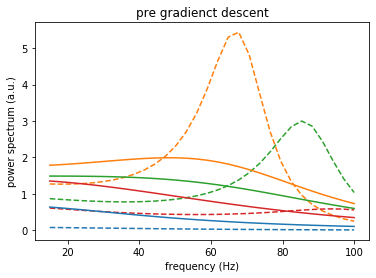

In [14]:
# params_init = np.array([2.5, 1.3, 2.4,  1.0, 1.0]) # [Jee, Jei, Jie, Jii, i2e]
# params_init = np.array([1.7, 1.25, 2.2,  1.5, 1.2]) # [Jee, Jei, Jie, Jii, i2e]
params_init = np.array([2.5, 1.3, 2.4, 1.0, 1.0, 1.0, 0.6]) # ground_truth init parameters that converged -- no sigmoid! 
params_init= np.array([ 1.60943794, -0.26826397,  1.38629436, -0.69314718, -0., -0.69314718,  0.40546507]) # parameters that when sigmoided yield the above line
test_contrasts = np.array([0, 25, 50, 100])

## Ground truth Parameters
# ideal_params = [1.7, 1.525, 1.7, -0.5, 0.6]

import time
t0 = time.time()
init_spect, fs, f0, init_r_fp, _ = ssn_PS(params_init, test_contrasts)
tt = time.time()-t0
print("run time:", tt)

target_PS = losses.get_target_spect(fs, ground_truth=True)


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.set_prop_cycle(None)
ax.plot(fs, init_spect/np.mean(init_spect))
ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

0.4787612


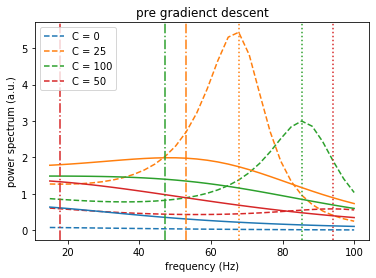

In [7]:
target_f0 = np.array(SSN_power_spec.find_peak_freq(fs, target_PS, len(test_contrasts)))
obs_f0 = np.array(SSN_power_spec.find_peak_freq(fs, init_spect, len(test_contrasts)))
color_order = ['tab:orange', 'tab:green', 'tab:red']
ind=0


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.legend({'C = 0', 'C = 25', 'C = 50', 'C = 100'})
for ff in target_f0:
    ax.axvline(x=ff, color=color_order[ind] , ls=':')
    ind += 1
ax.set_prop_cycle(None)
ax.plot(fs, init_spect/np.mean(init_spect))
ind=0
for ff in obs_f0:
    ax.axvline(x=ff, color=color_order[ind] , ls='-.')
    ind += 1

ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')


# plt.plot(fs[0:20], target_PS[0:20, :])
# ind = 0
# plt.legend({'C = 0', 'C = 25', 'C = 50', 'C = 100'})




    
print(losses.loss_peak_freq(obs_f0, target_f0))

# Run Gradient Descent

In [37]:
#dloss = grad(loss)
dloss = value_and_grad(loss)

gd_iters = 10
eta = .001 #learning rate

params = params_init
loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
if len(params) < 6:
    print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)
else:
    print("fit [Jee, Jei, Jie, Jii, gE, gI, NMDAratio] = ", params)

G.D. step  1


/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


G.D. step  2
G.D. step  3
G.D. step  4
G.D. step  5
G.D. step  6
G.D. step  7
G.D. step  8
G.D. step  9
G.D. step  10
10 GD steps took 43.37426996231079 seconds.
fit [Jee, Jei, Jie, Jii, gE, gI, NMDAratio] =  [2.493169   1.3191355  2.4041247  0.98356503 0.97700363 1.0240897
 0.6175825 ]


In [ ]:
## minimize instead
dloss = grad(loss)
# dloss = value_and_grad(loss)

def jac_dloss(params):
    gradient = onp.asarray(dloss(params))
    norm_grad.append(onp.linalg.norm(gradient))
    return gradient

def loss_hist(params):
    ll = onp.asarray(loss(params))
    loss_t.append(ll)
    return ll

# gd_iters = 1000
gd_iters = 10
eta = .001 #learning rate

params = params_init
loss_t = []
norm_grad = []

def c_back(xk):
    loss_t.append(xk.fun)
    norm_grad.append(np.norm(xk.jac))


t0 = time.time()

res = minimize(loss_hist, params, method='BFGS', jac=jac_dloss, options={'disp':True})#, 'maxiter':gd_iters})

params = res.x

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", sigmoid_params(params))


 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = Traced<ConcreteArray(nan)>with<JVPTrace(level=1/0)>,   xtol=1e-06.

Did not reach fixed point.

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.

 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.


/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)
/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


In [ ]:
obs_spect, fs, f0, obs_rates, _ = ssn_PS(params, test_contrasts)
obs_spect = np.real(obs_spect/np.mean(np.real(obs_spect)))
init_spect = np.real(init_spect/np.mean(np.real(init_spect)))
cons = len(test_contrasts)
target_rates = losses.get_target_rates()
lower_bound_rates = -5 * np.ones([2, cons-1])
upper_bound_rates = np.vstack((70*np.ones(cons-1), 100*np.ones(cons-1)))

make_plot.power_spect_rates_plot(fs, obs_spect, target_PS, test_contrasts, obs_rates.T, target_rates.T, init_spect, init_r_fp.T, lower_bound_rates, upper_bound_rates)

In [10]:
sigmoid_params(params)

DeviceArray([2.18886566, 0.72473621, 2.5256443, 0.58229268, 0.63058102,
             0.72763097, 0.387306 ], dtype=float32)

/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


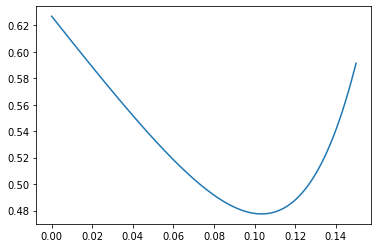

In [21]:
gradient_init = dloss(params_init)
gradient_init = gradient_init/np.linalg.norm(gradient_init)

x = np.linspace(0, 0.15, 200)
loss_grad = []
for ii in x:
    loss_grad.append(loss(params_init - ii*gradient_init))
plt.plot(x, loss_grad)

In [20]:
loss_grad

[DeviceArray(0.62683094, dtype=float32),
 DeviceArray(0.62196666, dtype=float32),
 DeviceArray(0.61711526, dtype=float32),
 DeviceArray(0.612277, dtype=float32),
 DeviceArray(0.6074532, dtype=float32),
 DeviceArray(0.60264635, dtype=float32),
 DeviceArray(0.59785736, dtype=float32),
 DeviceArray(0.5930869, dtype=float32),
 DeviceArray(0.5883384, dtype=float32),
 DeviceArray(0.58361405, dtype=float32),
 DeviceArray(0.57891566, dtype=float32),
 DeviceArray(0.5742459, dtype=float32),
 DeviceArray(0.5696074, dtype=float32),
 DeviceArray(0.5650044, dtype=float32),
 DeviceArray(0.5604401, dtype=float32),
 DeviceArray(0.55591565, dtype=float32),
 DeviceArray(0.5514391, dtype=float32),
 DeviceArray(0.54701275, dtype=float32),
 DeviceArray(0.5426423, dtype=float32),
 DeviceArray(0.5383323, dtype=float32),
 DeviceArray(0.53408784, dtype=float32),
 DeviceArray(0.5299167, dtype=float32),
 DeviceArray(0.52582574, dtype=float32),
 DeviceArray(0.5218206, dtype=float32),
 DeviceArray(0.5179099, dtype=


 Warning 1: reached Tmax=500, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = nan,   xtol=1e-06.

Did not reach fixed point.


/Users/cholt/miniconda3/envs/juC/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'frequency (Hz)')

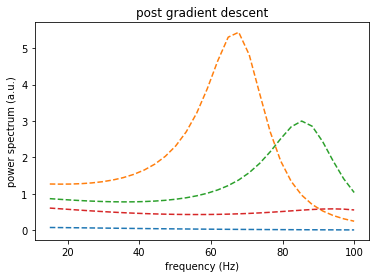

In [24]:
spect, fs, f0, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

In [7]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

NameError: name 'params' is not defined

In [7]:
half_width_rates = 20 # basin around acceptable rates 
lower_bound_rates = 5
upper_bound_rates = 80
kink_control = 1

print(losses.loss_rates_contrasts(r_fp, lower_bound_rates, upper_bound_rates, kink_control))
print(losses.loss_params(params))
print(losses.loss_spect_contrasts(fs, np.real(spect)))

0.03629179
0.0
0.630738


Text(0.5, 0, 'Contrast')

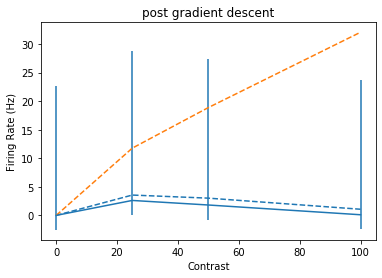

In [156]:
target_rates = losses.get_target_rates()
rates_error = target_rates - r_fp
# lower_bound_rates = losses.myReLu(half_width_rates/kink_control)
# upper_bound_rates = losses.myReLu(-half_width_rates/kink_control)

fig_rates, ax_rates = plt.subplots(1,1)
ax_rates.plot(test_contrasts, target_rates.T, "--")
#colrs = ax.get_color_cycle()
ax_rates.set_prop_cycle(None)
# ax_rates.plot(test_contrasts, r_fp.T)
ax_rates.set_prop_cycle(None)
# ax_rates.plot(test_contrasts, lower_bound_rates.T, '^')
# ax_rates.set_prop_cycle(None)
# ax_rates.plot(test_contrasts, upper_bound_rates.T, '^')
# ax_rates.errorbar(test_contrasts, r_fp[0,:].T, np.array([[upper_bound_rates[0,:]], [lower_bound_rates[0,:]]]) )
plt.errorbar(test_contrasts,r_fp[0,:], yerr=(e_error), fmt='')
ax_rates.set_title('post gradient descent')
ax_rates.set_ylabel('Firing Rate (Hz)')
ax_rates.set_xlabel('Contrast')

# plt.plot(test_contrasts,r_fp.T)

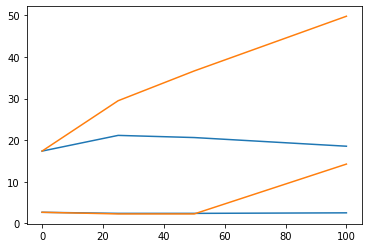

In [203]:
import numpy as onp

x = np.linspace(-30, 30, 10000)
cons = len(test_contrasts)
upper_bound_rates = onp.zeros((2, cons))
lower_bound_rates = onp.zeros((2, cons))


rates_range = np.linspace(-30, 100, 1000)
for ei in [0,1]:
    for con in np.arange(cons):
        error_range = target_rates[ei, con] - rates_range
        if target_rates[ei, con] - half_width_rates < 0:
            lower_half_width = target_rates[ei, con]
        else:
             lower_half_width = half_width_rates
        
        lower_curve = losses.myReLu((error_range - lower_half_width)/kink_control)
        higher_curve = losses.myReLu((-error_range - half_width_rates)/kink_control)
        
        upper_bound_rates[ei, con] = np.max(rates_range[higher_curve+lower_curve < 0.5])
        lower_bound_rates[ei, con] = np.min(rates_range[higher_curve+lower_curve < 0.5])

        

# upper_bound = losses.myReLu((error_range - half_width_rates)/kink_control)
# lower_bound = losses.myReLu((-error_range - half_width_rates)/kink_control)

e_error = np.vstack(([-lower_bound_rates[0,:]], [upper_bound_rates[0,:]])) 
i_error = np.vstack(([-lower_bound_rates[1,:]], [upper_bound_rates[1,:]])) 

# plt.plot(rates_range, upper_bound + lower_bound)
# plt.plot(x, yy)
fig, ax = plt.subplots(1,1)
ax.plot(test_contrasts, upper_bound_rates.T)
ax.set_prop_cycle(None)
ax.plot(test_contrasts, lower_bound_rates.T)


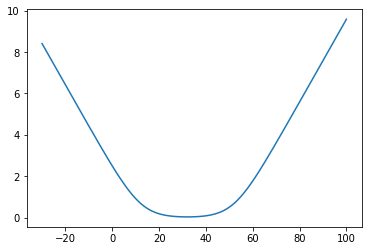

In [204]:
plt.plot(rates_range, lower_curve + higher_curve)

Text(0.5, 1.0, 'I Rates')

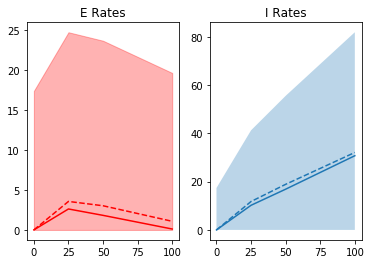

In [208]:
fig_split, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(test_contrasts, target_rates[0,:], "r--")
ax1.set_prop_cycle(None)
ax1.plot(test_contrasts, r_fp[0,:],"r")
# ax1.fill_between(test_contrasts, r_fp[0,:] + e_error[1,:], r_fp[0,:] - np.abs(e_error[0,:]), color='r', alpha=0.3)
ax1.fill_between(test_contrasts, target_rates[0,:] + e_error[1,:], 0, color='r', alpha=0.3)
ax1.set_title('E Rates')

ax2.plot(test_contrasts, target_rates[1,:], "--")
ax2.set_prop_cycle(None)
ax2.plot(test_contrasts, r_fp[1,:])
# ax2.fill_between(test_contrasts, r_fp[1,:] + i_error[1,:], r_fp[1,:] - np.abs(i_error[0,:]), alpha=0.3)
ax2.fill_between(test_contrasts, target_rates[1,:] + i_error[1,:], 0, alpha=0.3)
ax2.set_title('I Rates')

(4,)

In [190]:
r_fp[1,:]

DeviceArray([ 0.      , 10.20130444, 16.86116791, 30.71611214],
            dtype=float32)

In [13]:
import scipy.io as sio

sio.loadmat("pyGf.mat")

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Sep 23 15:32:59 2019',
 '__version__': '1.0',
 '__globals__': [],
 'pyGf': array([[-1.5552526-0.28274333j,  0.       +0.j        ,
         -2.5552526+0.j        ,  0.       +0.j        ,
         -2.5552526+0.j        ,  0.       +0.j        ],
        [-3.3067973+0.j        ,  1.       -0.28274333j,
         -3.3067973+0.j        ,  0.       +0.j        ,
         -3.3067973+0.j        ,  0.       +0.j        ],
        [ 0.       +0.j        ,  4.385322 +0.j        ,
          1.       -0.4712389j ,  4.385322 +0.j        ,
          0.       +0.j        ,  4.385322 +0.j        ],
        [ 0.       +0.j        ,  5.262387 +0.j        ,
          0.       +0.j        ,  6.262387 -0.4712389j ,
          0.       +0.j        ,  5.262387 +0.j        ],
        [-1.7035017+0.j        ,  0.       +0.j        ,
         -1.7035017+0.j        ,  0.       +0.j        ,
         -0.7035017-9.424778j  ,  0.       +0.j       

In [17]:
params = np.array([2.2825129 , 1.19606304, 2.42050719, 1.10869896, 0.683061  ,
             0.75365162, 0.33148643])

ideal_params = np.array([1.7, 1.525, 1.7, 0.5, 0.6])
# print('Init Parameters ', params_ini)
print('Parameter order is Jee, Jei, Jie, Jii, gE, gI, nmdaRatio')
print('Found Parameters ', params)

print('Ground Truth Parameters ', ideal_params)
print('Ground Truth nmdaRatio ', 0.1)

Parameter order is Jee, Jei, Jie, Jii, gE, gI, nmdaRatio
Found Parameters  [2.282513   1.196063   2.4205072  1.108699   0.683061   0.7536516
 0.33148643]
Ground Truth Parameters  [ 1.7    1.525  1.7   -0.5    0.6  ]
Ground Truth nmdaRatio  0.1


In [11]:
import scipy.io as sio

In [12]:
Results = {'res': res, 'params':params, 'obs_spect':obs_spect, 'obs_rates':obs_rates, 'params_init':params_init, 'init_spect':init_spect, 'init_rates':init_r_fp}
sio.savemat('BFGS_PS-GroundTruth-Conv.mat', Results)